In [1]:
import pandas as pd
import gensim.downloader as api

import seaborn as sns
from sklearn.utils import shuffle

from corpusholder import Lang, CorpusHolder
from model import Model, Learner

In [2]:
gensim_model = api.load("glove-wiki-gigaword-100")
print('gensim_model loaded')

gensim_model loaded


data=(249354, 11)
Lang=30002
CorpusHolder train_dataset=199472 val_dataset=24934 test_dataset=24935


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Liked', ylabel='count'>

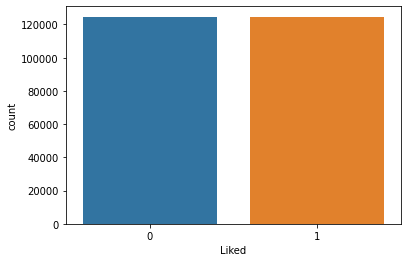

In [3]:
data = pd.read_csv('./amazon_foods/Reviews.csv')
data['Liked'] = data['Score'].apply(lambda x : 1 if x >= 4 else 0)

negatives = data[data.Liked == 0]
positives = data[data.Liked == 1].sample(n=len(negatives), random_state=1000007)
data = shuffle(positives.append(negatives).reset_index(drop=True))
print('data=%s' % str(data.shape))
corpus_holder = CorpusHolder(data['Text'].values, data['Liked'].values)
sns.countplot(data['Liked'])

In [4]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Liked
33696,458515,B000FFIL92,A1XFTCY4VJ3GZ5,mgirl,0,0,5,1328054400,nice,"love the unique array of teas, and the unusual...",1
100875,193265,B000EA3M92,ARRSPNXLWHE75,Toni A. Ritchey,1,1,5,1269561600,i will never use white refined sugar again,i find the sucanat to be a delicious product a...,1
86327,187925,B001Q9EGFY,A26DCH8BNG0BTO,"K. King ""K King""",0,0,4,1255564800,"Crunchy treats, mixed review",I have 2 cats with somewhat different opinions...,1
48189,540888,B0000DG718,AL7031O7EH7ZR,"Cheryl A. Mc Ilvain ""CHERYL""",1,1,5,1174003200,CHERYL,THIS IS THE FRESHEST SMOKED TROUT I HAVE ORDER...,1
54032,209414,B000LKTZ96,AA34TRZOWKY6A,"Phebe Vance ""WISkye""",3,3,5,1217548800,WisSkye,We love this product. In fact we use it in pre...,1


### hyperparameters search

let us try to use BOHB - Bayesian Optimization On Hyperband
<br>
https://www.automl.org/blog_bohb/
<br>
https://arxiv.org/abs/1807.01774
<br>
https://automl.github.io/HpBandSter/build/html/quickstart.html

In [5]:
%pip install hpbandster

Note: you may need to restart the kernel to use updated packages.


In [6]:
import ConfigSpace as CS
from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
from hpbandster.optimizers import BOHB
import logging
import datetime
import pickle

logger = logging.getLogger('hpbandster')
logger.setLevel(logging.ERROR)

BEST_ACC = 0.6

config_space = CS.ConfigurationSpace()
config_space.add_hyperparameter(CS.UniformIntegerHyperparameter('gru_hidden_size', lower=10, upper=526))
config_space.add_hyperparameter(CS.UniformIntegerHyperparameter('gru_num_layers', lower=1, upper=3))
config_space.add_hyperparameter(CS.UniformFloatHyperparameter('gru_dropout', lower=1e-9, upper=0.9, log=True))
config_space.add_hyperparameter(CS.CategoricalHyperparameter('gru_bidirectional', choices=[True, False]))
config_space.add_hyperparameter(CS.UniformIntegerHyperparameter('fc_size', lower=10, upper=526))
config_space.add_hyperparameter(CS.UniformFloatHyperparameter('learning_rate', lower=1e-5, upper=1e-3, log=True))
config_space.add_hyperparameter(CS.UniformFloatHyperparameter('weight_decay', lower=1e-9, upper=1e-1, log=True))

class LearnerWorker(Worker):
    def compute(self, config, budget, **kwargs):
        
#         # BOHB will visit with 1, 3, 11, 33 and 100% budgets
#         # let us map somehow onto n_epochs
#         # max_epoch = 7
#         # min_epoch = 2
#         if abs(1 - budget) < 1:
#             n_epoch = 1
#         elif abs(3 - budget) < 1:
#             n_epoch = 2
#         elif abs(11 - budget) < 1:
#             n_epoch = 3            
#         elif abs(33 - budget) < 1:
#             n_epoch = 4        
#         elif abs(100 - budget) < 1:
#             n_epoch = 7            
#         print('budget=%.2f n_epoch=%i' % (budget, n_epoch))

        n_epoch = 12
        model_config = {'embedding_freeze': True, 
                        'gru_hidden_size': config['gru_hidden_size'], 
                        'gru_num_layers': config['gru_num_layers'],
                        'gru_dropout': config['gru_dropout'], 
                        'gru_bidirectional': config['gru_bidirectional'], 
                        'fc_size': config['fc_size'], 
                        'n_classes': 2}

        trymodel = Model(corpus_holder.lang, gensim_model, model_config)

        learner_config = {'learning_rate': config['learning_rate'],
                          'n_epoch': n_epoch, 
                          'weight_decay':config['weight_decay'],
                          'verbose': False}
                                
        learner = Learner(trymodel, learner_config)       
        val_acc, test_acc = learner.train(corpus_holder, budget)

        info = {'model_config': model_config,
                'learner_config': learner_config,
                'budget': budget,
                'n_epoch': n_epoch,
                'val_acc': val_acc,
                'test_acc': test_acc}
        print('%s > %s' % (str(datetime.datetime.now()), str(info)))
        
        global BEST_ACC
        if test_acc > BEST_ACC:
            BEST_ACC = test_acc
            print('saving bohb.ckpt')
            learner.save("bohb.ckpt")

        return({ 'loss': val_acc,  # this is the a mandatory field to run hyperband
                 'info': info  # can be used for any user-defined information - also mandatory
               })


NS = hpns.NameServer(run_id='amazon_foods_model_bohb', host='127.0.0.1', port=None)
NS.start()
                                
# could be many if not my GPU RAM of 6Gb
worker1 = LearnerWorker(nameserver='127.0.0.1',run_id='amazon_foods_model_bohb')
worker1.run(background=True)
min_budget = 1
max_budget = 100
bohb = BOHB(configspace = config_space,logger=logger,
            run_id = 'amazon_foods_model_bohb', nameserver='127.0.0.1',
            min_budget=min_budget, max_budget=max_budget)

res = bohb.run(n_iterations=7)
                                
bohb.shutdown(shutdown_workers=True)
NS.shutdown()
                                
id2config = res.get_id2config_mapping()
incumbent = res.get_incumbent_id()

print('Best found configuration:', res.get_runs_by_id(incumbent)[-1])
print('A total of %i unique configurations where sampled.' % len(id2config.keys()))
print('A total of %i runs where executed.' % len(res.get_all_runs()))
print('Total budget corresponds to %.1f full function evaluations.'%(sum([r.budget for r in res.get_all_runs()])/max_budget))

with open('bohb.res.pickle','wb') as outfile:
    pickle.dump(res, outfile)
print('bohb.res.pickle saved')

/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.
/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1975960363265237 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


produced budgeted=1.23  train dataset=2462
produced budgeted=1.23  val dataset=1000
2020-12-06 11:09:47.217573 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 74, 'gru_num_layers': 1, 'gru_dropout': 0.1975960363265237, 'gru_bidirectional': False, 'fc_size': 144, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.5665550092573702e-05, 'n_epoch': 12, 'weight_decay': 1.5796556848285177e-05, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.524, 'test_acc': 0.5189492680970523}
2020-12-06 11:10:19.430430 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 293, 'gru_num_layers': 3, 'gru_dropout': 0.6123513309484869, 'gru_bidirectional': False, 'fc_size': 130, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00013582047864934361, 'n_epoch': 12, 'weight_decay': 0.0009787487739822153, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.736, 'test_acc': 0.7282534589933828}
saving bohb.ckpt
2020-12-06 11:1

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.06845808653229933 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:12:21.455025 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 251, 'gru_num_layers': 1, 'gru_dropout': 0.06845808653229933, 'gru_bidirectional': False, 'fc_size': 407, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.181918705632439e-05, 'n_epoch': 12, 'weight_decay': 1.1350129122200086e-08, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.558, 'test_acc': 0.5616202125526368}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=4.843159985770128e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:12:40.067319 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 268, 'gru_num_layers': 1, 'gru_dropout': 4.843159985770128e-06, 'gru_bidirectional': True, 'fc_size': 343, 'n_classes': 2}, 'learner_config': {'learning_rate': 2.223353949433801e-05, 'n_epoch': 12, 'weight_decay': 5.216783394320714e-08, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.662, 'test_acc': 0.660798074994987}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.007579902490028778 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:12:51.534798 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 180, 'gru_num_layers': 1, 'gru_dropout': 0.007579902490028778, 'gru_bidirectional': False, 'fc_size': 494, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00037230984500918386, 'n_epoch': 12, 'weight_decay': 2.0471406275461758e-07, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.728, 'test_acc': 0.7388008822939643}
2020-12-06 11:13:15.661728 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 85, 'gru_num_layers': 2, 'gru_dropout': 0.03281069480853666, 'gru_bidirectional': True, 'fc_size': 460, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0004795226632037503, 'n_epoch': 12, 'weight_decay': 0.0024016069972259274, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.752, 'test_acc': 0.740806095849208}
saving bohb.ckpt
2020-12-06 11:13:41.363802 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 167, 'g

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.058061789727547e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:15:41.600863 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 217, 'gru_num_layers': 1, 'gru_dropout': 1.058061789727547e-07, 'gru_bidirectional': False, 'fc_size': 427, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00022623212848292415, 'n_epoch': 12, 'weight_decay': 5.707578282253464e-08, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.753, 'test_acc': 0.7384399438540205}
2020-12-06 11:16:06.453433 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 155, 'gru_num_layers': 3, 'gru_dropout': 0.41674252226793385, 'gru_bidirectional': False, 'fc_size': 170, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0006371533440394095, 'n_epoch': 12, 'weight_decay': 0.05103051512119927, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.2387149144340774e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:16:19.345961 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 201, 'gru_num_layers': 1, 'gru_dropout': 1.2387149144340774e-07, 'gru_bidirectional': False, 'fc_size': 60, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0001268396257081486, 'n_epoch': 12, 'weight_decay': 0.06725910839593136, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.513, 'test_acc': 0.5035091237216763}
2020-12-06 11:16:58.120896 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 361, 'gru_num_layers': 3, 'gru_dropout': 0.0030632068003393796, 'gru_bidirectional': False, 'fc_size': 188, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00013539692504410238, 'n_epoch': 12, 'weight_decay': 1.2429150968305733e-08, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.717, 'test_acc': 0.7158612392219771}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


2020-12-06 11:17:19.379465 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 29, 'gru_num_layers': 2, 'gru_dropout': 0.1294780390435865, 'gru_bidirectional': True, 'fc_size': 111, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.3916605477617698e-05, 'n_epoch': 12, 'weight_decay': 3.9325038545464405e-08, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.547, 'test_acc': 0.542690996591137}
2020-12-06 11:17:40.818434 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 276, 'gru_num_layers': 2, 'gru_dropout': 4.947064740138367e-05, 'gru_bidirectional': False, 'fc_size': 70, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.0534819454279973e-05, 'n_epoch': 12, 'weight_decay': 0.027926726256488853, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.56, 'test_acc': 0.5632644876679367}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.04095640508702672 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:17:55.068797 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 266, 'gru_num_layers': 1, 'gru_dropout': 0.04095640508702672, 'gru_bidirectional': False, 'fc_size': 407, 'n_classes': 2}, 'learner_config': {'learning_rate': 3.0434291682852165e-05, 'n_epoch': 12, 'weight_decay': 9.2862558821216e-07, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.636, 'test_acc': 0.6542209745337878}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.45138174319143193 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:18:29.458867 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 526, 'gru_num_layers': 1, 'gru_dropout': 0.45138174319143193, 'gru_bidirectional': True, 'fc_size': 397, 'n_classes': 2}, 'learner_config': {'learning_rate': 8.290184166615313e-05, 'n_epoch': 12, 'weight_decay': 1.3054175567720108e-07, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.759, 'test_acc': 0.7400441146982154}
2020-12-06 11:18:51.475752 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 42, 'gru_num_layers': 2, 'gru_dropout': 0.03483166479524551, 'gru_bidirectional': True, 'fc_size': 72, 'n_classes': 2}, 'learner_config': {'learning_rate': 5.3746971393853745e-05, 'n_epoch': 12, 'weight_decay': 6.014899404533097e-07, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.651, 'test_acc': 0.6488068979346301}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0019008001567649433 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:19:02.877017 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 64, 'gru_num_layers': 1, 'gru_dropout': 0.0019008001567649433, 'gru_bidirectional': False, 'fc_size': 106, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.0935135689227713e-05, 'n_epoch': 12, 'weight_decay': 0.0004657729736145436, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.56, 'test_acc': 0.526609183878083}
2020-12-06 11:19:38.791228 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 498, 'gru_num_layers': 2, 'gru_dropout': 0.5643213934514957, 'gru_bidirectional': False, 'fc_size': 326, 'n_classes': 2}, 'learner_config': {'learning_rate': 6.09399634550194e-05, 'n_epoch': 12, 'weight_decay': 5.285536030108244e-06, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.743, 'test_acc': 0.7339883697613796}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=8.108349083287763e-08 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:19:52.154843 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 209, 'gru_num_layers': 1, 'gru_dropout': 8.108349083287763e-08, 'gru_bidirectional': False, 'fc_size': 106, 'n_classes': 2}, 'learner_config': {'learning_rate': 6.719701213328171e-05, 'n_epoch': 12, 'weight_decay': 0.00017114497735320564, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.732, 'test_acc': 0.7220774012432324}
2020-12-06 11:20:12.142828 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 71, 'gru_num_layers': 3, 'gru_dropout': 0.026460365174581942, 'gru_bidirectional': False, 'fc_size': 25, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.1899309159572751e-05, 'n_epoch': 12, 'weight_decay': 1.6974239357777592e-08, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.541, 'test_acc': 0.5184680168437938}
2020-12-06 11:20:34.667693 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 282, 'gru_num_layers

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/statsmodels/nonparametric/kernels.py:62: RuntimeWarning: divide by zero encountered in true_divide
  kernel_value = np.ones(Xi.size) * h / (num_levels - 1)


2020-12-06 11:22:40.915662 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 67, 'gru_num_layers': 3, 'gru_dropout': 0.000180882382881929, 'gru_bidirectional': False, 'fc_size': 73, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.527032207809625e-05, 'n_epoch': 12, 'weight_decay': 0.0038102916274067662, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.533, 'test_acc': 0.5312612793262482}
2020-12-06 11:24:03.273658 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 384, 'gru_num_layers': 3, 'gru_dropout': 1.6105148555932857e-05, 'gru_bidirectional': True, 'fc_size': 104, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.758962180075294e-05, 'n_epoch': 12, 'weight_decay': 1.238432464896485e-05, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.724, 'test_acc': 0.721876879887708}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.03878775927776659 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:24:35.995422 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 510, 'gru_num_layers': 1, 'gru_dropout': 0.03878775927776659, 'gru_bidirectional': True, 'fc_size': 434, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.1392937158370311e-05, 'n_epoch': 12, 'weight_decay': 2.109631692065924e-09, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.636, 'test_acc': 0.6405454180870263}
2020-12-06 11:25:05.712581 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 34, 'gru_num_layers': 3, 'gru_dropout': 4.078977631749047e-06, 'gru_bidirectional': True, 'fc_size': 222, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0003680484519443218, 'n_epoch': 12, 'weight_decay': 7.252542173237351e-09, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.763, 'test_acc': 0.7444956887908563}
saving bohb.ckpt
2020-12-06 11:25:56.635259 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 194, 'g

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.345580164227908e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:26:44.106388 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 209, 'gru_num_layers': 1, 'gru_dropout': 1.345580164227908e-05, 'gru_bidirectional': False, 'fc_size': 34, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0006805467053932413, 'n_epoch': 12, 'weight_decay': 0.0013331360896966476, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.726, 'test_acc': 0.7321836775616604}
2020-12-06 11:27:05.960804 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 118, 'gru_num_layers': 3, 'gru_dropout': 0.2396366259376709, 'gru_bidirectional': False, 'fc_size': 155, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00043598436137178345, 'n_epoch': 12, 'weight_decay': 0.012156741983284213, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.744, 'test_acc': 0.7239221977140565}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=2.634646967752703e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:27:18.013319 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 83, 'gru_num_layers': 1, 'gru_dropout': 2.634646967752703e-05, 'gru_bidirectional': False, 'fc_size': 19, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.083513261849364e-05, 'n_epoch': 12, 'weight_decay': 3.470508489598105e-05, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.523, 'test_acc': 0.5201925005013034}
2020-12-06 11:27:38.067118 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 65, 'gru_num_layers': 3, 'gru_dropout': 1.6229703413374685e-07, 'gru_bidirectional': False, 'fc_size': 95, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0001662705096423123, 'n_epoch': 12, 'weight_decay': 0.017985153726435305, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.566, 'test_acc': 0.5658311610186485}
2020-12-06 11:27:53.596704 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 87, 'gru_num_layers': 2,

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5208792633040261 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:28:05.971970 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 107, 'gru_num_layers': 1, 'gru_dropout': 0.5208792633040261, 'gru_bidirectional': False, 'fc_size': 185, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.0585956758348863e-05, 'n_epoch': 12, 'weight_decay': 0.00017168043889149043, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.523, 'test_acc': 0.5148586324443554}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23811008083302493 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:28:18.802483 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 150, 'gru_num_layers': 1, 'gru_dropout': 0.23811008083302493, 'gru_bidirectional': False, 'fc_size': 207, 'n_classes': 2}, 'learner_config': {'learning_rate': 4.462799049559603e-05, 'n_epoch': 12, 'weight_decay': 0.000589462156904389, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.621, 'test_acc': 0.6146781632243834}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=4.11431584232405e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:28:31.098253 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 102, 'gru_num_layers': 1, 'gru_dropout': 4.11431584232405e-05, 'gru_bidirectional': False, 'fc_size': 90, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.6536924520620913e-05, 'n_epoch': 12, 'weight_decay': 1.8752274571735478e-06, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.52, 'test_acc': 0.5119711249248045}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=2.184159031754324e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:28:43.197857 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 86, 'gru_num_layers': 1, 'gru_dropout': 2.184159031754324e-06, 'gru_bidirectional': False, 'fc_size': 20, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.428750287291356e-05, 'n_epoch': 12, 'weight_decay': 0.02710710488981324, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031882895528373}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=7.801634621847263e-09 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:28:58.840454 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 302, 'gru_num_layers': 1, 'gru_dropout': 7.801634621847263e-09, 'gru_bidirectional': False, 'fc_size': 198, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0004921411362792367, 'n_epoch': 12, 'weight_decay': 1.9294108163213612e-07, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.761, 'test_acc': 0.7467014237016242}
saving bohb.ckpt


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=3.900429313996058e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:29:10.911387 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 68, 'gru_num_layers': 1, 'gru_dropout': 3.900429313996058e-07, 'gru_bidirectional': False, 'fc_size': 87, 'n_classes': 2}, 'learner_config': {'learning_rate': 7.210034642074841e-05, 'n_epoch': 12, 'weight_decay': 0.041634856815269815, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.512, 'test_acc': 0.5047122518548225}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=2.388319737500465e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:29:23.430016 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 117, 'gru_num_layers': 1, 'gru_dropout': 2.388319737500465e-06, 'gru_bidirectional': False, 'fc_size': 43, 'n_classes': 2}, 'learner_config': {'learning_rate': 5.207543108826182e-05, 'n_epoch': 12, 'weight_decay': 5.0865627077361766e-08, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.61, 'test_acc': 0.6103067976739522}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=2.0841758626078317e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:29:35.906066 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 109, 'gru_num_layers': 1, 'gru_dropout': 2.0841758626078317e-07, 'gru_bidirectional': False, 'fc_size': 74, 'n_classes': 2}, 'learner_config': {'learning_rate': 6.695109097240907e-05, 'n_epoch': 12, 'weight_decay': 0.023279201471492518, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.529, 'test_acc': 0.5165831161018648}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=3.0191169588741026e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:29:53.783612 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 211, 'gru_num_layers': 1, 'gru_dropout': 3.0191169588741026e-07, 'gru_bidirectional': True, 'fc_size': 442, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.780341362123325e-05, 'n_epoch': 12, 'weight_decay': 1.6175385829558458e-05, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.609, 'test_acc': 0.622979747343092}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=6.83141245665712e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:30:05.582802 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 72, 'gru_num_layers': 1, 'gru_dropout': 6.83141245665712e-05, 'gru_bidirectional': False, 'fc_size': 392, 'n_classes': 2}, 'learner_config': {'learning_rate': 7.719997701265549e-05, 'n_epoch': 12, 'weight_decay': 4.250932650186466e-09, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.651, 'test_acc': 0.6328052937637858}
2020-12-06 11:30:30.483966 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 150, 'gru_num_layers': 3, 'gru_dropout': 0.6776960681424022, 'gru_bidirectional': False, 'fc_size': 328, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.6965544111829538e-05, 'n_epoch': 12, 'weight_decay': 0.006942822729443401, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.534, 'test_acc': 0.5273310607579708}
2020-12-06 11:30:45.315225 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 32, 'gru_num_layers': 2, 

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=7.412060697797015e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:31:27.891430 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 31, 'gru_num_layers': 1, 'gru_dropout': 7.412060697797015e-07, 'gru_bidirectional': False, 'fc_size': 117, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.8316827040402497e-05, 'n_epoch': 12, 'weight_decay': 0.009596919016708241, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.487, 'test_acc': 0.5006617204732304}
2020-12-06 11:32:04.217295 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 222, 'gru_num_layers': 2, 'gru_dropout': 0.002887297745091721, 'gru_bidirectional': True, 'fc_size': 336, 'n_classes': 2}, 'learner_config': {'learning_rate': 3.812910404327334e-05, 'n_epoch': 12, 'weight_decay': 1.9883600426362553e-09, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.746, 'test_acc': 0.7255263685582515}
2020-12-06 11:32:29.432023 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 176, 'gru_num_layers':

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.540764207636601e-09 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:32:41.522240 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 50, 'gru_num_layers': 1, 'gru_dropout': 1.540764207636601e-09, 'gru_bidirectional': False, 'fc_size': 147, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00027007225674091564, 'n_epoch': 12, 'weight_decay': 0.0079267813535658, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.665, 'test_acc': 0.6678163224383397}
2020-12-06 11:32:57.045484 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 82, 'gru_num_layers': 2, 'gru_dropout': 1.6124052943989599e-09, 'gru_bidirectional': False, 'fc_size': 37, 'n_classes': 2}, 'learner_config': {'learning_rate': 2.8069301688961443e-05, 'n_epoch': 12, 'weight_decay': 0.0029508693318483145, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.557, 'test_acc': 0.5483858030880289}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.023147389727283793 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:33:21.787246 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 359, 'gru_num_layers': 1, 'gru_dropout': 0.023147389727283793, 'gru_bidirectional': True, 'fc_size': 476, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.604662519177909e-05, 'n_epoch': 12, 'weight_decay': 1.2971656965057137e-09, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.648, 'test_acc': 0.6649689191898938}
2020-12-06 11:35:23.448380 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 479, 'gru_num_layers': 3, 'gru_dropout': 0.00011441610834483915, 'gru_bidirectional': True, 'fc_size': 226, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0003641475653844969, 'n_epoch': 12, 'weight_decay': 2.8077038972589865e-08, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.73, 'test_acc': 0.7178664527772207}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.00012066798403675314 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:35:35.535472 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 96, 'gru_num_layers': 1, 'gru_dropout': 0.00012066798403675314, 'gru_bidirectional': False, 'fc_size': 34, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00017399353667660604, 'n_epoch': 12, 'weight_decay': 0.016284046517211697, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.615, 'test_acc': 0.5927812312011229}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=3.343043804721705e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:35:47.776759 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 62, 'gru_num_layers': 1, 'gru_dropout': 3.343043804721705e-05, 'gru_bidirectional': False, 'fc_size': 79, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.905765569065458e-05, 'n_epoch': 12, 'weight_decay': 0.06397197817750476, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.502, 'test_acc': 0.4959695207539603}
2020-12-06 11:36:02.992438 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 34, 'gru_num_layers': 2, 'gru_dropout': 6.709711681167685e-06, 'gru_bidirectional': False, 'fc_size': 26, 'n_classes': 2}, 'learner_config': {'learning_rate': 3.0288439167208335e-05, 'n_epoch': 12, 'weight_decay': 0.004233595774878623, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.53, 'test_acc': 0.5194305193503108}
2020-12-06 11:36:38.142783 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 73, 'gru_num_layers': 3, 'g

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0006239141933491201 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:37:05.559446 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 64, 'gru_num_layers': 1, 'gru_dropout': 0.0006239141933491201, 'gru_bidirectional': False, 'fc_size': 76, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.9486003788978245e-05, 'n_epoch': 12, 'weight_decay': 0.0048504811195856715, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.508, 'test_acc': 0.508040906356527}
2020-12-06 11:37:32.235428 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 144, 'gru_num_layers': 2, 'gru_dropout': 0.1822382099007657, 'gru_bidirectional': True, 'fc_size': 92, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0002853635511573383, 'n_epoch': 12, 'weight_decay': 7.308238394601821e-06, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.751, 'test_acc': 0.7444154802486465}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.4989695977688468e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:37:57.895852 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 392, 'gru_num_layers': 1, 'gru_dropout': 1.4989695977688468e-06, 'gru_bidirectional': True, 'fc_size': 38, 'n_classes': 2}, 'learner_config': {'learning_rate': 2.4097740196957983e-05, 'n_epoch': 12, 'weight_decay': 0.03463975339347122, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.572, 'test_acc': 0.5598957288951273}
2020-12-06 11:38:14.637098 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 131, 'gru_num_layers': 2, 'gru_dropout': 0.018565545493299217, 'gru_bidirectional': False, 'fc_size': 151, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0003144971157522377, 'n_epoch': 12, 'weight_decay': 0.06209468442704456, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.3887885088540843e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:38:28.155212 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 163, 'gru_num_layers': 1, 'gru_dropout': 1.3887885088540843e-07, 'gru_bidirectional': False, 'fc_size': 32, 'n_classes': 2}, 'learner_config': {'learning_rate': 2.7506889040630835e-05, 'n_epoch': 12, 'weight_decay': 0.025896654832915814, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5033487066372568}
2020-12-06 11:38:43.595541 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 88, 'gru_num_layers': 2, 'gru_dropout': 0.23059443928623888, 'gru_bidirectional': False, 'fc_size': 146, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0004874639978899696, 'n_epoch': 12, 'weight_decay': 0.006530260087761414, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.753, 'test_acc': 0.7361941046721476}
2020-12-06 11:39:09.926644 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 368, 'gru_num_layers': 2

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=6.836429860946761e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:39:47.436757 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 49, 'gru_num_layers': 1, 'gru_dropout': 6.836429860946761e-06, 'gru_bidirectional': False, 'fc_size': 115, 'n_classes': 2}, 'learner_config': {'learning_rate': 3.318571849629199e-05, 'n_epoch': 12, 'weight_decay': 0.08082509990698838, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.524, 'test_acc': 0.49805494285141366}
2020-12-06 11:40:09.081547 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 110, 'gru_num_layers': 3, 'gru_dropout': 0.005132016929463498, 'gru_bidirectional': False, 'fc_size': 152, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0007319102904800754, 'n_epoch': 12, 'weight_decay': 0.03160217089077869, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.1171181384647455e-08 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:40:30.793749 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 312, 'gru_num_layers': 1, 'gru_dropout': 1.1171181384647455e-08, 'gru_bidirectional': True, 'fc_size': 271, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0001367395572932786, 'n_epoch': 12, 'weight_decay': 0.04169522953036176, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.519, 'test_acc': 0.5135351914978945}
2020-12-06 11:40:50.729149 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 47, 'gru_num_layers': 3, 'gru_dropout': 0.0022509334943042938, 'gru_bidirectional': False, 'fc_size': 74, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0002467489452904228, 'n_epoch': 12, 'weight_decay': 1.294410980056521e-05, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.741, 'test_acc': 0.7308602366151995}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0002955255438187258 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:41:05.723578 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 21, 'gru_num_layers': 1, 'gru_dropout': 0.0002955255438187258, 'gru_bidirectional': True, 'fc_size': 252, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.000149043404854519, 'n_epoch': 12, 'weight_decay': 0.00019461827704519757, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.662, 'test_acc': 0.6512532584720273}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=3.2313945642554197e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 11:41:20.220295 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 191, 'gru_num_layers': 1, 'gru_dropout': 3.2313945642554197e-06, 'gru_bidirectional': False, 'fc_size': 73, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.0123258957185283e-05, 'n_epoch': 12, 'weight_decay': 0.03227229469633626, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.504, 'test_acc': 0.5013835973531181}
2020-12-06 11:41:38.433104 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 170, 'gru_num_layers': 2, 'gru_dropout': 0.0008306186250116223, 'gru_bidirectional': False, 'fc_size': 132, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0004518429737545716, 'n_epoch': 12, 'weight_decay': 0.010688470891313908, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.738, 'test_acc': 0.7252857429316222}
produced budgeted=3.70  train dataset=7387
produced budgeted=3.70  val dataset=1000
2020-12-06 11:41:56.582651 > {

2020-12-06 11:49:59.629086 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 62, 'gru_num_layers': 1, 'gru_dropout': 3.343043804721705e-05, 'gru_bidirectional': False, 'fc_size': 79, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.905765569065458e-05, 'n_epoch': 12, 'weight_decay': 0.06397197817750476, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.498, 'test_acc': 0.49737317024263084}
2020-12-06 11:50:24.552893 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 34, 'gru_num_layers': 2, 'gru_dropout': 6.709711681167685e-06, 'gru_bidirectional': False, 'fc_size': 26, 'n_classes': 2}, 'learner_config': {'learning_rate': 3.0288439167208335e-05, 'n_epoch': 12, 'weight_decay': 0.004233595774878623, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.566, 'test_acc': 0.5760978544214959}
2020-12-06 11:51:41.457427 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 73, 'gru_num_layers': 3, 

produced budgeted=33.33  train dataset=66490
produced budgeted=33.33  val dataset=8311
2020-12-06 12:11:07.462091 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 155, 'gru_num_layers': 3, 'gru_dropout': 0.41674252226793385, 'gru_bidirectional': False, 'fc_size': 170, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0006371533440394095, 'n_epoch': 12, 'weight_decay': 0.05103051512119927, 'verbose': False}, 'budget': 33.33333333333333, 'n_epoch': 12, 'val_acc': 0.49717242209120444, 'test_acc': 0.49689191898937235}
2020-12-06 12:12:28.133532 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 68, 'gru_num_layers': 1, 'gru_dropout': 3.900429313996058e-07, 'gru_bidirectional': False, 'fc_size': 87, 'n_classes': 2}, 'learner_config': {'learning_rate': 7.210034642074841e-05, 'n_epoch': 12, 'weight_decay': 0.041634856815269815, 'verbose': False}, 'budget': 33.33333333333333, 'n_epoch': 12, 'val_acc': 0.5028275779087956, 'test_acc': 0.5031080810106277}
2020-1

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=5.249954518772718e-08 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 12:38:52.203015 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 197, 'gru_num_layers': 1, 'gru_dropout': 5.249954518772718e-08, 'gru_bidirectional': False, 'fc_size': 88, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0008888861329524339, 'n_epoch': 12, 'weight_decay': 0.06410841846038402, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 12:39:33.691986 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 98, 'gru_num_layers': 3, 'gru_dropout': 1.4490566617607813e-07, 'gru_bidirectional': False, 'fc_size': 77, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005205663799739491, 'n_epoch': 12, 'weight_decay': 0.038624210008110296, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 12:40:20.791753 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 290, 'gru_num_layers': 

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=2.465591902680185e-09 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 12:48:47.274624 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 302, 'gru_num_layers': 1, 'gru_dropout': 2.465591902680185e-09, 'gru_bidirectional': False, 'fc_size': 344, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00036283761632242476, 'n_epoch': 12, 'weight_decay': 4.442064530927084e-06, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.787, 'test_acc': 0.7825546420693804}
saving bohb.ckpt


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0772282680338616 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 12:49:06.913698 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 105, 'gru_num_layers': 1, 'gru_dropout': 0.0772282680338616, 'gru_bidirectional': False, 'fc_size': 175, 'n_classes': 2}, 'learner_config': {'learning_rate': 9.626530425113548e-05, 'n_epoch': 12, 'weight_decay': 0.054526622685116335, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=2.2552359167577138e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 12:49:24.690672 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 36, 'gru_num_layers': 1, 'gru_dropout': 2.2552359167577138e-07, 'gru_bidirectional': False, 'fc_size': 57, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00043431692331809946, 'n_epoch': 12, 'weight_decay': 0.05225688015592416, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=6.5576039156053105e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 12:49:43.489387 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 144, 'gru_num_layers': 1, 'gru_dropout': 6.5576039156053105e-06, 'gru_bidirectional': False, 'fc_size': 246, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00029144609216984034, 'n_epoch': 12, 'weight_decay': 0.045847984340773064, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 12:50:40.625619 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 161, 'gru_num_layers': 3, 'gru_dropout': 9.220664773285632e-05, 'gru_bidirectional': False, 'fc_size': 29, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00014502793954190166, 'n_epoch': 12, 'weight_decay': 1.7167893174351076e-09, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.78, 'test_acc': 0.7668337677962703}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.010307448255946157 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 12:51:00.110225 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 114, 'gru_num_layers': 1, 'gru_dropout': 0.010307448255946157, 'gru_bidirectional': False, 'fc_size': 219, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0009994405467391987, 'n_epoch': 12, 'weight_decay': 0.04634329257755988, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=2.767345405176717e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 12:51:25.092797 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 79, 'gru_num_layers': 1, 'gru_dropout': 2.767345405176717e-07, 'gru_bidirectional': True, 'fc_size': 134, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00023593643591810634, 'n_epoch': 12, 'weight_decay': 0.0456755103768676, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.589, 'test_acc': 0.6003609384399439}
2020-12-06 12:53:34.234765 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 504, 'gru_num_layers': 3, 'gru_dropout': 0.06622021937016509, 'gru_bidirectional': False, 'fc_size': 394, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0002679368847615153, 'n_epoch': 12, 'weight_decay': 0.010950018542045439, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.75, 'test_acc': 0.744575897333066}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.9822832567898295e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 12:53:54.783362 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 196, 'gru_num_layers': 1, 'gru_dropout': 1.9822832567898295e-05, 'gru_bidirectional': False, 'fc_size': 270, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.000704434106314307, 'n_epoch': 12, 'weight_decay': 0.04997571231943126, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=3.547989065986578e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 12:54:12.621878 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 14, 'gru_num_layers': 1, 'gru_dropout': 3.547989065986578e-05, 'gru_bidirectional': False, 'fc_size': 36, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0004797078713422782, 'n_epoch': 12, 'weight_decay': 0.06179289749906767, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 12:54:38.412131 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 64, 'gru_num_layers': 2, 'gru_dropout': 0.08244011297754641, 'gru_bidirectional': False, 'fc_size': 263, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0001608849737040871, 'n_epoch': 12, 'weight_decay': 0.0268307478323954, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.501, 'test_acc': 0.49725285742931624}
2020-12-06 12:55:14.114836 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 56, 'gru_num_layers': 3, 'gr

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.5613199787854388e-09 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 12:56:18.235391 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 55, 'gru_num_layers': 1, 'gru_dropout': 1.5613199787854388e-09, 'gru_bidirectional': True, 'fc_size': 56, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.0824333904040024e-05, 'n_epoch': 12, 'weight_decay': 0.056517001852966584, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.532, 'test_acc': 0.5418087026268298}
2020-12-06 12:57:38.643377 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 174, 'gru_num_layers': 2, 'gru_dropout': 5.105495772931744e-05, 'gru_bidirectional': False, 'fc_size': 154, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0007774360911785336, 'n_epoch': 12, 'weight_decay': 0.040656370876517064, 'verbose': False}, 'budget': 11.11111111111111, 'n_epoch': 12, 'val_acc': 0.5021660649819495, 'test_acc': 0.49689191898937235}
2020-12-06 12:59:08.140524 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 88, 'gru_n

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.010238249620416123 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 13:21:51.543252 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 319, 'gru_num_layers': 1, 'gru_dropout': 0.010238249620416123, 'gru_bidirectional': False, 'fc_size': 51, 'n_classes': 2}, 'learner_config': {'learning_rate': 3.604225355914979e-05, 'n_epoch': 12, 'weight_decay': 0.003381038848908786, 'verbose': False}, 'budget': 11.11111111111111, 'n_epoch': 12, 'val_acc': 0.7498194945848375, 'test_acc': 0.75275716863846}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=3.398045143524451e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 13:22:38.710208 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 194, 'gru_num_layers': 1, 'gru_dropout': 3.398045143524451e-07, 'gru_bidirectional': False, 'fc_size': 279, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0009386971140989731, 'n_epoch': 12, 'weight_decay': 0.04586731764723149, 'verbose': False}, 'budget': 11.11111111111111, 'n_epoch': 12, 'val_acc': 0.5021660649819495, 'test_acc': 0.49689191898937235}
2020-12-06 13:25:23.508042 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 146, 'gru_num_layers': 2, 'gru_dropout': 0.11665735519830261, 'gru_bidirectional': True, 'fc_size': 501, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0002204238133848538, 'n_epoch': 12, 'weight_decay': 9.891043687929721e-05, 'verbose': False}, 'budget': 11.11111111111111, 'n_epoch': 12, 'val_acc': 0.8036101083032491, 'test_acc': 0.7987968718668538}
saving bohb.ckpt
2020-12-06 13:30:32.467328 > {'model_config': {'embedding_freeze': True, 'g

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=4.238992157692175e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 13:33:02.426582 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 11, 'gru_num_layers': 1, 'gru_dropout': 4.238992157692175e-06, 'gru_bidirectional': False, 'fc_size': 109, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0007100352062943372, 'n_epoch': 12, 'weight_decay': 0.07186896639721753, 'verbose': False}, 'budget': 11.11111111111111, 'n_epoch': 12, 'val_acc': 0.5021660649819495, 'test_acc': 0.49689191898937235}
2020-12-06 13:38:48.422800 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 483, 'gru_num_layers': 3, 'gru_dropout': 1.7891302851152155e-06, 'gru_bidirectional': False, 'fc_size': 446, 'n_classes': 2}, 'learner_config': {'learning_rate': 9.466443980627396e-05, 'n_epoch': 12, 'weight_decay': 0.04611730631138196, 'verbose': False}, 'budget': 11.11111111111111, 'n_epoch': 12, 'val_acc': 0.5021660649819495, 'test_acc': 0.49689191898937235}
2020-12-06 13:43:09.187012 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size'

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.456163857752319e-09 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 14:34:41.730019 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 410, 'gru_num_layers': 1, 'gru_dropout': 1.456163857752319e-09, 'gru_bidirectional': False, 'fc_size': 504, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00041887290723340953, 'n_epoch': 12, 'weight_decay': 0.05389781272938748, 'verbose': False}, 'budget': 33.33333333333333, 'n_epoch': 12, 'val_acc': 0.5028275779087956, 'test_acc': 0.5031080810106277}
2020-12-06 14:38:40.337999 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 39, 'gru_num_layers': 3, 'gru_dropout': 0.19937682301086582, 'gru_bidirectional': False, 'fc_size': 38, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0007196819431678783, 'n_epoch': 12, 'weight_decay': 0.036014651808057865, 'verbose': False}, 'budget': 33.33333333333333, 'n_epoch': 12, 'val_acc': 0.5028275779087956, 'test_acc': 0.5031080810106277}
2020-12-06 14:57:10.187440 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 23

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0026993229200475127 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 15:13:09.619367 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 318, 'gru_num_layers': 1, 'gru_dropout': 0.0026993229200475127, 'gru_bidirectional': False, 'fc_size': 394, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0004760419019297432, 'n_epoch': 12, 'weight_decay': 0.04680592462989196, 'verbose': False}, 'budget': 33.33333333333333, 'n_epoch': 12, 'val_acc': 0.5028275779087956, 'test_acc': 0.5031080810106277}
2020-12-06 15:26:53.186617 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 89, 'gru_num_layers': 3, 'gru_dropout': 0.002936621734636118, 'gru_bidirectional': False, 'fc_size': 38, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0007615393383673319, 'n_epoch': 12, 'weight_decay': 0.02816400015510449, 'verbose': False}, 'budget': 100.0, 'n_epoch': 12, 'val_acc': 0.5017245528194433, 'test_acc': 0.49689191898937235}
2020-12-06 15:51:42.422315 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 427, 'gru_num_

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=5.4524998302360705e-09 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 16:55:24.235343 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 358, 'gru_num_layers': 1, 'gru_dropout': 5.4524998302360705e-09, 'gru_bidirectional': False, 'fc_size': 26, 'n_classes': 2}, 'learner_config': {'learning_rate': 7.381579456385109e-05, 'n_epoch': 12, 'weight_decay': 7.151985500981423e-09, 'verbose': False}, 'budget': 100.0, 'n_epoch': 12, 'val_acc': 0.8594689981551296, 'test_acc': 0.8550230599558853}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.3563824526735345e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 16:59:17.143120 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 51, 'gru_num_layers': 1, 'gru_dropout': 1.3563824526735345e-06, 'gru_bidirectional': False, 'fc_size': 79, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0009108838522023478, 'n_epoch': 12, 'weight_decay': 0.06343860616445475, 'verbose': False}, 'budget': 100.0, 'n_epoch': 12, 'val_acc': 0.5017245528194433, 'test_acc': 0.49689191898937235}
2020-12-06 16:59:40.179466 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 115, 'gru_num_layers': 3, 'gru_dropout': 7.3692998652361e-05, 'gru_bidirectional': False, 'fc_size': 75, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005139537429581388, 'n_epoch': 12, 'weight_decay': 0.04317003542639567, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.7090319538471307e-08 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:00:05.031195 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 342, 'gru_num_layers': 1, 'gru_dropout': 1.7090319538471307e-08, 'gru_bidirectional': True, 'fc_size': 386, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0004175014028408318, 'n_epoch': 12, 'weight_decay': 2.2575554846595745e-09, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.733, 'test_acc': 0.7135351914978946}
2020-12-06 17:00:29.494408 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 291, 'gru_num_layers': 2, 'gru_dropout': 5.778996998324084e-08, 'gru_bidirectional': False, 'fc_size': 479, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00045642580196837354, 'n_epoch': 12, 'weight_decay': 0.04396192299980745, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:01:19.167255 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 169, 'gru_num_layers

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=6.244447847712891e-09 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:04:39.025441 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 283, 'gru_num_layers': 1, 'gru_dropout': 6.244447847712891e-09, 'gru_bidirectional': False, 'fc_size': 401, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0002805477503291891, 'n_epoch': 12, 'weight_decay': 0.03469227918584767, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:05:15.687801 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 318, 'gru_num_layers': 3, 'gru_dropout': 3.038726301038162e-09, 'gru_bidirectional': False, 'fc_size': 360, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0006727954800490289, 'n_epoch': 12, 'weight_decay': 0.04690667084861311, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=3.9432334955544015e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:05:31.045573 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 243, 'gru_num_layers': 1, 'gru_dropout': 3.9432334955544015e-06, 'gru_bidirectional': False, 'fc_size': 140, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00011247919931438129, 'n_epoch': 12, 'weight_decay': 5.81476373309959e-08, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.74, 'test_acc': 0.7347904551834771}
2020-12-06 17:05:52.332005 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 61, 'gru_num_layers': 3, 'gru_dropout': 0.15382118527283326, 'gru_bidirectional': False, 'fc_size': 244, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0006746756719715295, 'n_epoch': 12, 'weight_decay': 0.04467210810001651, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:06:25.934003 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 274, 'gru_num_layers': 3,

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0009376978896087642 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:07:28.382061 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 287, 'gru_num_layers': 1, 'gru_dropout': 0.0009376978896087642, 'gru_bidirectional': True, 'fc_size': 274, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00034622377086119, 'n_epoch': 12, 'weight_decay': 0.02883078408289145, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.624, 'test_acc': 0.6382193703629436}
2020-12-06 17:07:50.088326 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 112, 'gru_num_layers': 3, 'gru_dropout': 0.005174404646285704, 'gru_bidirectional': False, 'fc_size': 92, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005390520073346445, 'n_epoch': 12, 'weight_decay': 0.06747959641807338, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:09:57.126058 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 503, 'gru_num_layers': 3, 'gr

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=4.122311709378905e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:12:47.074600 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 277, 'gru_num_layers': 1, 'gru_dropout': 4.122311709378905e-05, 'gru_bidirectional': False, 'fc_size': 413, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0006229453783156042, 'n_epoch': 12, 'weight_decay': 0.04384286346860215, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=2.947587028588486e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:13:11.313716 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 507, 'gru_num_layers': 1, 'gru_dropout': 2.947587028588486e-07, 'gru_bidirectional': False, 'fc_size': 248, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0003376436911244621, 'n_epoch': 12, 'weight_decay': 1.9354832378009759e-07, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.737, 'test_acc': 0.7308201323440946}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=4.346631559545638e-09 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:13:31.517750 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 387, 'gru_num_layers': 1, 'gru_dropout': 4.346631559545638e-09, 'gru_bidirectional': False, 'fc_size': 504, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00032369275567608886, 'n_epoch': 12, 'weight_decay': 0.06027338579121315, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:13:51.583457 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 25, 'gru_num_layers': 3, 'gru_dropout': 0.01370454347390278, 'gru_bidirectional': False, 'fc_size': 42, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0004373058385030518, 'n_epoch': 12, 'weight_decay': 0.04699417469637386, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:15:18.022441 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 514, 'gru_num_layers': 2, '

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.00015846201554796038 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:15:31.239139 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 25, 'gru_num_layers': 1, 'gru_dropout': 0.00015846201554796038, 'gru_bidirectional': False, 'fc_size': 154, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00033760692007465064, 'n_epoch': 12, 'weight_decay': 0.054734703214348826, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.54, 'test_acc': 0.5219971927010226}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=2.358488482049341e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:15:50.722808 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 370, 'gru_num_layers': 1, 'gru_dropout': 2.358488482049341e-05, 'gru_bidirectional': False, 'fc_size': 348, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005320282411083339, 'n_epoch': 12, 'weight_decay': 0.041677888521340134, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=6.69106245470915e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:16:04.062586 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 63, 'gru_num_layers': 1, 'gru_dropout': 6.69106245470915e-06, 'gru_bidirectional': False, 'fc_size': 67, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00042430601575964847, 'n_epoch': 12, 'weight_decay': 0.04946355523365497, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:16:32.181658 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 182, 'gru_num_layers': 3, 'gru_dropout': 0.749470485381065, 'gru_bidirectional': False, 'fc_size': 127, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0009430173730287797, 'n_epoch': 12, 'weight_decay': 0.055468429444654674, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:16:58.952126 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 344, 'gru_num_layers': 2, 'gr

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.239136617383562e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:19:16.040995 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 257, 'gru_num_layers': 1, 'gru_dropout': 1.239136617383562e-05, 'gru_bidirectional': False, 'fc_size': 123, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00032996240163725817, 'n_epoch': 12, 'weight_decay': 0.04868441065896374, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:19:37.147954 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 213, 'gru_num_layers': 2, 'gru_dropout': 0.003012936816077924, 'gru_bidirectional': False, 'fc_size': 88, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0008887368184895641, 'n_epoch': 12, 'weight_decay': 0.04014298729803137, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=4.9897313753285804e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:19:50.333684 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 27, 'gru_num_layers': 1, 'gru_dropout': 4.9897313753285804e-05, 'gru_bidirectional': False, 'fc_size': 46, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0007186607901522904, 'n_epoch': 12, 'weight_decay': 0.05927375591057747, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:20:17.101998 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 337, 'gru_num_layers': 2, 'gru_dropout': 1.3281032134922577e-09, 'gru_bidirectional': False, 'fc_size': 509, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00030032221177102406, 'n_epoch': 12, 'weight_decay': 0.023466602455272, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.629, 'test_acc': 0.637457389211951}
2020-12-06 17:20:47.832355 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 223, 'gru_num_layers': 3, 

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=6.796030928495688e-09 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:21:05.765041 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 169, 'gru_num_layers': 1, 'gru_dropout': 6.796030928495688e-09, 'gru_bidirectional': True, 'fc_size': 369, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00019424134793708049, 'n_epoch': 12, 'weight_decay': 6.551009095634126e-08, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.734, 'test_acc': 0.731662322037297}
2020-12-06 17:21:57.877179 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 187, 'gru_num_layers': 3, 'gru_dropout': 0.0012259178406411363, 'gru_bidirectional': True, 'fc_size': 338, 'n_classes': 2}, 'learner_config': {'learning_rate': 1.967421353492243e-05, 'n_epoch': 12, 'weight_decay': 1.893864341160627e-05, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.71, 'test_acc': 0.7051533988369761}
2020-12-06 17:22:26.374303 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 369, 'gru_num_layers': 

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=5.115995978019202e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:22:39.632064 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 10, 'gru_num_layers': 1, 'gru_dropout': 5.115995978019202e-07, 'gru_bidirectional': False, 'fc_size': 129, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0007973971470582473, 'n_epoch': 12, 'weight_decay': 0.06740277082633916, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.512, 'test_acc': 0.5033888109083617}
2020-12-06 17:23:11.155148 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 242, 'gru_num_layers': 3, 'gru_dropout': 6.593997458763267e-08, 'gru_bidirectional': False, 'fc_size': 415, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005350419718441003, 'n_epoch': 12, 'weight_decay': 0.03262933935628648, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:23:41.655404 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 408, 'gru_num_layers': 2,

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.3588114116231108e-09 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:25:26.254217 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 383, 'gru_num_layers': 1, 'gru_dropout': 1.3588114116231108e-09, 'gru_bidirectional': False, 'fc_size': 495, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00033091958406129336, 'n_epoch': 12, 'weight_decay': 0.03346762823675097, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:25:50.458862 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 261, 'gru_num_layers': 2, 'gru_dropout': 4.467805942220352e-09, 'gru_bidirectional': False, 'fc_size': 281, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0008787764965921648, 'n_epoch': 12, 'weight_decay': 0.03673751900905352, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:26:31.313904 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 264, 'gru_num_layers':

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0011335918266489407 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:28:33.675134 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 37, 'gru_num_layers': 1, 'gru_dropout': 0.0011335918266489407, 'gru_bidirectional': False, 'fc_size': 14, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005194476604962351, 'n_epoch': 12, 'weight_decay': 0.0518033891898752, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.497, 'test_acc': 0.49953880088229397}
2020-12-06 17:28:54.057808 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 35, 'gru_num_layers': 3, 'gru_dropout': 0.011819755085469837, 'gru_bidirectional': False, 'fc_size': 289, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005393359006795781, 'n_epoch': 12, 'weight_decay': 0.027132695777832457, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.512, 'test_acc': 0.5032283938239422}
2020-12-06 17:29:15.966567 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 244, 'gru_num_layers': 2, '

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=4.508265848487764e-06 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:29:51.065067 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 45, 'gru_num_layers': 1, 'gru_dropout': 4.508265848487764e-06, 'gru_bidirectional': False, 'fc_size': 134, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00025877529823042494, 'n_epoch': 12, 'weight_decay': 0.060201679187153696, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:30:11.330952 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 29, 'gru_num_layers': 3, 'gru_dropout': 0.0006187940924200069, 'gru_bidirectional': False, 'fc_size': 150, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.000925697799467164, 'n_epoch': 12, 'weight_decay': 0.04168925090625109, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:30:27.433001 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 40, 'gru_num_layers': 2, 

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.2443225629221013e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:31:17.400453 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 385, 'gru_num_layers': 1, 'gru_dropout': 1.2443225629221013e-07, 'gru_bidirectional': False, 'fc_size': 521, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0003513086628142786, 'n_epoch': 12, 'weight_decay': 0.029652657507533067, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:31:39.242632 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 87, 'gru_num_layers': 3, 'gru_dropout': 0.12040347394975846, 'gru_bidirectional': False, 'fc_size': 444, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0008782973686298387, 'n_epoch': 12, 'weight_decay': 0.04227695816680834, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:32:04.898843 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 143, 'gru_num_layers': 3,

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=7.961229411730679e-08 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:33:48.472073 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 325, 'gru_num_layers': 1, 'gru_dropout': 7.961229411730679e-08, 'gru_bidirectional': False, 'fc_size': 458, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00036720780509041673, 'n_epoch': 12, 'weight_decay': 0.04600217289488075, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:34:10.551889 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 239, 'gru_num_layers': 2, 'gru_dropout': 2.8928957933452887e-09, 'gru_bidirectional': False, 'fc_size': 428, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005982375107373347, 'n_epoch': 12, 'weight_decay': 0.051977162373499905, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:34:30.227707 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 177, 'gru_num_layers'

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.3618693142035356e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:34:50.409276 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 218, 'gru_num_layers': 1, 'gru_dropout': 1.3618693142035356e-05, 'gru_bidirectional': True, 'fc_size': 49, 'n_classes': 2}, 'learner_config': {'learning_rate': 2.787975095035176e-05, 'n_epoch': 12, 'weight_decay': 0.09507178840585706, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.553, 'test_acc': 0.5750150391016643}
2020-12-06 17:35:07.275126 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 85, 'gru_num_layers': 2, 'gru_dropout': 0.017004856439019264, 'gru_bidirectional': False, 'fc_size': 440, 'n_classes': 2}, 'learner_config': {'learning_rate': 3.360700998299923e-05, 'n_epoch': 12, 'weight_decay': 7.34664512759597e-08, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.618, 'test_acc': 0.6016442751152998}
2020-12-06 17:35:28.018347 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 37, 'gru_num_layers': 3, '

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=3.714007052493536e-09 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 17:35:41.352082 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 20, 'gru_num_layers': 1, 'gru_dropout': 3.714007052493536e-09, 'gru_bidirectional': False, 'fc_size': 41, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00041765066328116826, 'n_epoch': 12, 'weight_decay': 0.08197624840665357, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:36:00.559589 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 28, 'gru_num_layers': 3, 'gru_dropout': 0.33676958624039155, 'gru_bidirectional': False, 'fc_size': 53, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0006082199804241096, 'n_epoch': 12, 'weight_decay': 0.02721237799578522, 'verbose': False}, 'budget': 1.2345679012345678, 'n_epoch': 12, 'val_acc': 0.511, 'test_acc': 0.5031080810106277}
2020-12-06 17:36:46.700504 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 115, 'gru_num_layers': 3, 'gr

2020-12-06 17:49:42.780951 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 94, 'gru_num_layers': 3, 'gru_dropout': 0.05308359301239096, 'gru_bidirectional': False, 'fc_size': 41, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0006753837978599309, 'n_epoch': 12, 'weight_decay': 0.034670831569427615, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 17:50:01.275426 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 45, 'gru_num_layers': 1, 'gru_dropout': 4.508265848487764e-06, 'gru_bidirectional': False, 'fc_size': 134, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00025877529823042494, 'n_epoch': 12, 'weight_decay': 0.060201679187153696, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.501, 'test_acc': 0.5031080810106277}
2020-12-06 17:50:37.523046 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 29, 'gru_num_layers': 3, 

2020-12-06 18:17:55.850317 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 115, 'gru_num_layers': 3, 'gru_dropout': 7.3692998652361e-05, 'gru_bidirectional': False, 'fc_size': 75, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005139537429581388, 'n_epoch': 12, 'weight_decay': 0.04317003542639567, 'verbose': False}, 'budget': 33.33333333333333, 'n_epoch': 12, 'val_acc': 0.5028275779087956, 'test_acc': 0.5031080810106277}
2020-12-06 18:24:42.715967 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 26, 'gru_num_layers': 3, 'gru_dropout': 0.00013354348186214181, 'gru_bidirectional': True, 'fc_size': 431, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0006995341503502903, 'n_epoch': 12, 'weight_decay': 0.06432894347621104, 'verbose': False}, 'budget': 33.33333333333333, 'n_epoch': 12, 'val_acc': 0.5028275779087956, 'test_acc': 0.5031080810106277}
2020-12-06 18:31:22.653676 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 151,

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.029654748725449858 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:47:21.554657 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 254, 'gru_num_layers': 1, 'gru_dropout': 0.029654748725449858, 'gru_bidirectional': False, 'fc_size': 273, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0008047599088967789, 'n_epoch': 12, 'weight_decay': 0.05298501574841017, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 18:48:26.934871 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 226, 'gru_num_layers': 3, 'gru_dropout': 6.903155565327366e-08, 'gru_bidirectional': False, 'fc_size': 477, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0007932090027247197, 'n_epoch': 12, 'weight_decay': 0.037062614499813476, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.00010730616207799353 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:48:57.238642 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 323, 'gru_num_layers': 1, 'gru_dropout': 0.00010730616207799353, 'gru_bidirectional': False, 'fc_size': 522, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0007064718915586792, 'n_epoch': 12, 'weight_decay': 4.9485838311519e-05, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.774, 'test_acc': 0.7718066974132746}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.004865332625724571 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:49:30.799406 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 359, 'gru_num_layers': 1, 'gru_dropout': 0.004865332625724571, 'gru_bidirectional': False, 'fc_size': 356, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0003975891964660866, 'n_epoch': 12, 'weight_decay': 0.04342692537264308, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.00021591649929868798 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:49:54.172911 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 203, 'gru_num_layers': 1, 'gru_dropout': 0.00021591649929868798, 'gru_bidirectional': False, 'fc_size': 503, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00041932245059406, 'n_epoch': 12, 'weight_decay': 0.0541976319837518, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 18:50:36.173733 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 243, 'gru_num_layers': 2, 'gru_dropout': 0.02197115233625475, 'gru_bidirectional': False, 'fc_size': 372, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0004954656576135435, 'n_epoch': 12, 'weight_decay': 0.04258444425277952, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1095070675302346 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:51:02.439323 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 259, 'gru_num_layers': 1, 'gru_dropout': 0.1095070675302346, 'gru_bidirectional': False, 'fc_size': 380, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005348718059985584, 'n_epoch': 12, 'weight_decay': 0.054539848349222576, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.02585286030450801 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:51:34.368362 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 342, 'gru_num_layers': 1, 'gru_dropout': 0.02585286030450801, 'gru_bidirectional': False, 'fc_size': 403, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005478179173766975, 'n_epoch': 12, 'weight_decay': 0.05073037528938059, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0001005897327031476 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:51:59.385517 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 92, 'gru_num_layers': 1, 'gru_dropout': 0.0001005897327031476, 'gru_bidirectional': True, 'fc_size': 29, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005565976881436555, 'n_epoch': 12, 'weight_decay': 3.138132693701368e-05, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.785, 'test_acc': 0.7916984158812913}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.12907062599911404 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:52:33.681728 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 388, 'gru_num_layers': 1, 'gru_dropout': 0.12907062599911404, 'gru_bidirectional': False, 'fc_size': 329, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0006283795972052209, 'n_epoch': 12, 'weight_decay': 0.05906429658644858, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=3.1194527639382236e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:52:52.356066 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 128, 'gru_num_layers': 1, 'gru_dropout': 3.1194527639382236e-07, 'gru_bidirectional': False, 'fc_size': 241, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.000736701141789644, 'n_epoch': 12, 'weight_decay': 0.04203850816933179, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 18:53:46.449995 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 172, 'gru_num_layers': 3, 'gru_dropout': 0.0054354461376465, 'gru_bidirectional': False, 'fc_size': 277, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00012606998027678097, 'n_epoch': 12, 'weight_decay': 3.999371651436537e-09, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.754, 'test_acc': 0.7461800681772609}
2020-12-06 18:55:38.246568 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 430, 'gru_num_layers': 

/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.003571875220394741 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:56:01.875682 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 211, 'gru_num_layers': 1, 'gru_dropout': 0.003571875220394741, 'gru_bidirectional': False, 'fc_size': 235, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005663843921834044, 'n_epoch': 12, 'weight_decay': 0.04499956257699461, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.013115912700774824 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:56:29.593094 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 289, 'gru_num_layers': 1, 'gru_dropout': 0.013115912700774824, 'gru_bidirectional': False, 'fc_size': 413, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0006267402857895399, 'n_epoch': 12, 'weight_decay': 0.052100667769405216, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 18:57:28.399588 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 22, 'gru_num_layers': 3, 'gru_dropout': 3.7146506252314397e-09, 'gru_bidirectional': True, 'fc_size': 437, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00024995068736724486, 'n_epoch': 12, 'weight_decay': 0.0023228452527916006, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.768, 'test_acc': 0.7640264688189292}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.0013342549575866424 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:57:50.843362 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 178, 'gru_num_layers': 1, 'gru_dropout': 0.0013342549575866424, 'gru_bidirectional': False, 'fc_size': 508, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0009619763465365218, 'n_epoch': 12, 'weight_decay': 0.04191534671391965, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.2272504771879623e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:58:15.694867 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 288, 'gru_num_layers': 1, 'gru_dropout': 1.2272504771879623e-05, 'gru_bidirectional': False, 'fc_size': 332, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.000724289313784027, 'n_epoch': 12, 'weight_decay': 0.04302041688383684, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.00627961175862785 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:58:40.306838 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 235, 'gru_num_layers': 1, 'gru_dropout': 0.00627961175862785, 'gru_bidirectional': False, 'fc_size': 367, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0008072829583269195, 'n_epoch': 12, 'weight_decay': 0.04049437599341004, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=4.762032875221817e-08 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:59:10.876894 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 329, 'gru_num_layers': 1, 'gru_dropout': 4.762032875221817e-08, 'gru_bidirectional': False, 'fc_size': 273, 'n_classes': 2}, 'learner_config': {'learning_rate': 4.8507629535114314e-05, 'n_epoch': 12, 'weight_decay': 0.005160346158988882, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.748, 'test_acc': 0.7415680770002006}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.0647739552025925e-07 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 18:59:38.117834 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 283, 'gru_num_layers': 1, 'gru_dropout': 1.0647739552025925e-07, 'gru_bidirectional': False, 'fc_size': 33, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0009618550389041854, 'n_epoch': 12, 'weight_decay': 0.04292627951450151, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 19:02:01.837771 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 403, 'gru_num_layers': 2, 'gru_dropout': 0.15728346850938554, 'gru_bidirectional': True, 'fc_size': 254, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00013078458983376253, 'n_epoch': 12, 'weight_decay': 2.059961272292534e-06, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.771, 'test_acc': 0.7643071987166633}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.013015050547296684 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 19:02:30.909595 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 310, 'gru_num_layers': 1, 'gru_dropout': 0.013015050547296684, 'gru_bidirectional': False, 'fc_size': 314, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.00046864404710208514, 'n_epoch': 12, 'weight_decay': 0.05768176246684355, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14667594128235875 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 19:03:06.142055 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 404, 'gru_num_layers': 1, 'gru_dropout': 0.14667594128235875, 'gru_bidirectional': False, 'fc_size': 365, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005369130969301759, 'n_epoch': 12, 'weight_decay': 0.03777161586600508, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 19:05:35.383480 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 255, 'gru_num_layers': 3, 'gru_dropout': 0.0003437511585402581, 'gru_bidirectional': True, 'fc_size': 143, 'n_classes': 2}, 'learner_config': {'learning_rate': 8.49842642902245e-05, 'n_epoch': 12, 'weight_decay': 1.3197917277944424e-06, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.77, 'test_acc': 0.7605373972328053}


/home/alexey/.conda/envs/py37/lib/python3.7/site-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=1.1960987988280188e-05 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


2020-12-06 19:06:07.017988 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 348, 'gru_num_layers': 1, 'gru_dropout': 1.1960987988280188e-05, 'gru_bidirectional': False, 'fc_size': 391, 'n_classes': 2}, 'learner_config': {'learning_rate': 0.0005015144117656459, 'n_epoch': 12, 'weight_decay': 0.04189513059863914, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.499, 'test_acc': 0.49689191898937235}
2020-12-06 19:06:53.047229 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 274, 'gru_num_layers': 2, 'gru_dropout': 4.0320736322264704e-07, 'gru_bidirectional': False, 'fc_size': 522, 'n_classes': 2}, 'learner_config': {'learning_rate': 2.0429989967931406e-05, 'n_epoch': 12, 'weight_decay': 3.0790029516494633e-07, 'verbose': False}, 'budget': 3.7037037037037033, 'n_epoch': 12, 'val_acc': 0.753, 'test_acc': 0.7418889111690395}
2020-12-06 19:07:47.258698 > {'model_config': {'embedding_freeze': True, 'gru_hidden_size': 254, 'gru_num_lay